<a href="https://colab.research.google.com/github/hodurang2/CV_project/blob/main/week4_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pwd

'/content'

In [ ]:
%cd /content/drive/MyDrive/CV_seminar_project

[Errno 2] No such file or directory: '/content/drive/MyDrive/CV_seminar_project'
/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 augmentation
import os
import glob
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)

In [ ]:
device

'cuda'

In [ ]:
root_path = '/content/drive/MyDrive/CV_seminar_project'
train_path = '/content/drive/MyDrive/CV_seminar_project/train'
test_path = '/content/drive/MyDrive/CV_seminar_project/test'

# pytorch 데이터셋 클래스 실습

### 1. 파이토치 데이터 셋 클래스를 직접 만들어보자.

파이토치 데이터 셋 클래스는 init, getitem, len 특수 메소드 3개를 요구한다.   
 항상 같은 포맷을 만드는 습관이 중요하다. 
> 따라서 root_path, mode(train or validation or test), transform(전처리&Augmentation) 3개의 입력을 받아 data와 label을 출력하는 클래스를 만들도록하자.


In [ ]:
from torch.utils.data import Dataset, DataLoader
import cv2
import os 

class Custom_dataset(Dataset):
  def __init__(self, root_path, mode, transforms):
    self.all_data = sorted( glob.glob( os.path.join(root_path, mode, '*', '*') ) ) # 전체 경로
    self.transforms = transforms

  def __getitem__(self, index):
    if torch.is_tensor(index): # 인덱스가 tensor형태일 수 있는 것을 방지
      index = index.tolist()

    data_path = self.all_data[index] # 인덱스가 부여된 데이터 1개
    image = cv2.imread(data_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2 라이브러리의 BGR 형식을 RGB로 permute

    # transfrom 적용
    if self.transforms is not None:
      augmentation = self.transforms(image = image)
      image = augmentation['image']

    # 이미지의 이름을 이용하여, label 부여하기
    if 'dolphin' in data_path:
      label = 0
    elif 'shark' in data_path:
      label = 1
    else:
      label = 2

    return image, label

  def __len__(self):
    length = len(self.all_data)
    return length

### 2. 전처리와 Augmentation을 적용한다.
> Normalize: 픽셀 값에 대해 (X - mean)/std를 진행하며, 이때 통계 값은 ImageNet 데이터 셋의 RGB 통계값을 이용할 것이다.
>   
> 텐서화: 파이토치는 tensor자료 형을 이용하므로 totensor를 해준다.   
>   
> augmentation: trainset에만 적용한다.


In [ ]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수

train_transforms = A.Compose([
    A.Resize(224,224), # 이미지 리사이즈
    A.Transpose(p=0.5), # 이미지 반전
    A.HorizontalFlip(p=0.5), 
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.ChannelShuffle(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    A.CoarseDropout(p=0.5),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])

### Pytorch 데이터 클래스 생성
train_class = Custom_dataset(root_path=root_path, mode='train', transforms=train_transforms)
valid_class = Custom_dataset(root_path=root_path, mode='valid', transforms=test_transforms)
test_class = Custom_dataset(root_path=root_path, mode='test', transforms=test_transforms)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
from torch.utils.data import DataLoader as DataLoader

train_loader = DataLoader(train_class, batch_size=8, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=8, shuffle = False, num_workers=0)
test_loader = DataLoader(test_class, batch_size=8, shuffle = False, num_workers=0) # 사실 필요하지않음

# week4 과제
아래와 같이 원래 0~255 픽셀 값을 가진 귀여운 돌고래 이미지는 Augmentation이 적용되어(train_class[0][0]) 이미지가 변형 되었다.   
**train_class[0][0] 데이터**를 시각화 할 수 있도록 시각화 라이브러리가 요구하는 numpy 타입의 올바른 이미지 데이터로 되돌리는 역함수를 만들어 시각화 해오는 것.   

결과물에 대해서는 week4 pdf의 과제 설명에 있는 이미지를 보시면 이해될 것입니다.

In [ ]:
train_class.all_data[9]

'/content/drive/MyDrive/CV_seminar_project/train/dolphin/dolphin121.jpg'

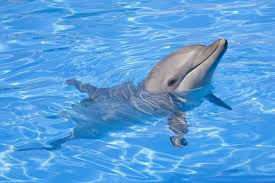

In [ ]:
from PIL import Image as PILImage
PILImage.open(train_class.all_data[9])

In [ ]:
train_class[9][0] # 역함수를 이용해 이것을 시각화 해주세요.

tensor([[[ 0.3309,  0.2796,  0.1597,  ...,  0.4166,  0.8104,  0.6049],
         [ 0.2111,  0.2282,  0.1426,  ...,  0.5022,  0.8104,  0.5707],
         [ 0.0912,  0.1597,  0.1254,  ...,  0.5536,  0.7591,  0.5193],
         ...,
         [ 0.5193,  0.4851,  0.5193,  ..., -0.0116, -0.1657, -0.2171],
         [ 0.5707,  0.5193,  0.5193,  ..., -0.0458, -0.1828, -0.1999],
         [ 0.5707,  0.5193,  0.5193,  ..., -0.0458, -0.1828, -0.2171]],

        [[-0.8452, -0.8803, -1.0378,  ..., -0.8102, -0.4251, -0.6527],
         [-0.9153, -0.9328, -1.0728,  ..., -0.7227, -0.4251, -0.6877],
         [-1.0203, -0.9853, -1.0553,  ..., -0.6877, -0.4776, -0.7227],
         ...,
         [-0.4776, -0.5126, -0.4951,  ..., -1.3354, -1.6155, -1.8081],
         [-0.4951, -0.5301, -0.5301,  ..., -1.4230, -1.7381, -1.9307],
         [-0.5126, -0.5476, -0.5301,  ..., -1.4055, -1.7206, -1.9132]],

        [[ 1.5942,  1.6291,  1.6117,  ...,  1.9428,  2.2566,  2.0300],
         [ 1.5071,  1.5420,  1.5594,  ...,  2

In [ ]:
def converter(augmentationed_image):
  ### 역함수 로직을 짜주세요. ###
  mean = (0.485, 0.456, 0.406)
  std = (0.229, 0.224, 0.225)

  converted_image = augmentationed_image.permute(1, 2, 0).numpy() # tensor는 C H W 로 구성되어있는것을 H W C로 permute후 넘파이로 변환
  converted_image = ((converted_image * std) + mean) * 255 # minmax스케일링 후 (X-mean)/std 이므로 ((X*std)+mean) * 255 해주어야함
  #print(type(converted_image))
  converted_image = converted_image.astype(int) # 위 상황이 됐을 경우 소수점까지 표현됨 그러나 이미지 출력은 int이므로 데이터타입 int로 변환해주어야함


  return converted_image

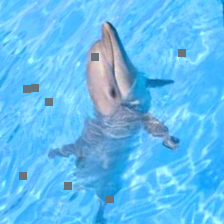

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(cv_img)

<class 'numpy.ndarray'>


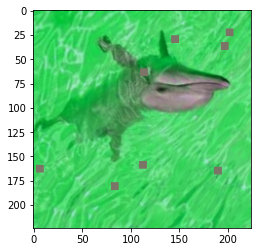

In [ ]:
cv_img = converter(train_class[9][0])
#cv_img = cv2.imread(cv_img1)
plt.imshow(cv_img)
